Dataset saved to grid_world_dataset.pkl with 894 samples.
Loaded dataset with 894 samples.


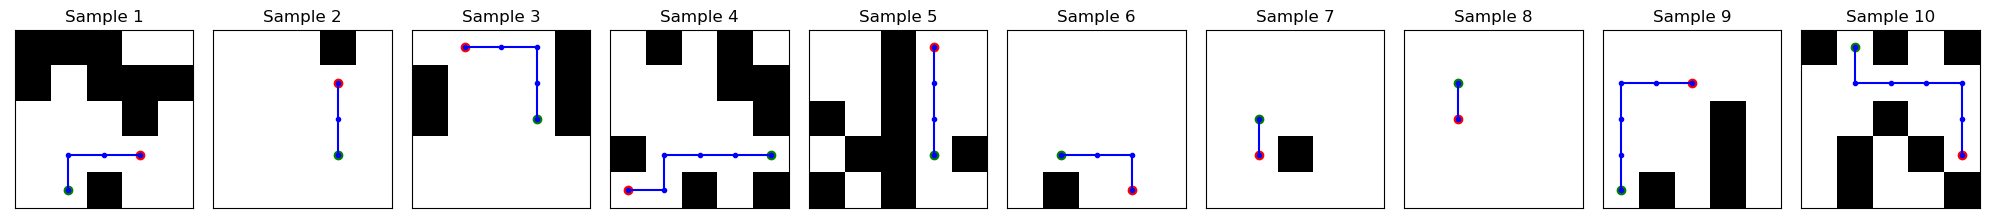

In [2]:
import numpy as np
import random
import torch
import pickle
import matplotlib.pyplot as plt
from queue import PriorityQueue
from torch.utils.data import Dataset
from collections import namedtuple

# Define the grid environment with obstacles
class GridEnvironment:
    def __init__(self, grid_size=5):
        self.grid_size = grid_size
        self.grid = np.zeros((grid_size, grid_size))  # Initialize grid with free cells

    def reset(self):
        self.grid = np.zeros((self.grid_size, self.grid_size))

    def add_obstacle(self, x, y):
        if self.is_valid(x, y):
            self.grid[int(x), int(y)] = 1  # Mark obstacle cells with 1

    def is_valid(self, x, y):
        x = int(x)
        y = int(y)
        return (
            0 <= x < self.grid_size and
            0 <= y < self.grid_size and
            self.grid[x, y] == 0  # Check if the cell is free
        )

# A* search algorithm to find the shortest path
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def astar_path(grid_env, start, goal):
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    open_set = PriorityQueue()
    open_set.put((0, tuple(start), [tuple(start)]))
    g_score = {tuple(start): 0}
    visited = set()

    while not open_set.empty():
        _, current_position, path = open_set.get()
        if current_position == tuple(goal):
            return np.array(path)
        visited.add(current_position)
        for direction in directions:
            new_position = (
                current_position[0] + direction[0],
                current_position[1] + direction[1],
            )
            if (
                grid_env.is_valid(new_position[0], new_position[1]) and
                new_position not in visited
            ):
                tentative_g_score = g_score[current_position] + 1
                if (
                    new_position not in g_score or
                    tentative_g_score < g_score[new_position]
                ):
                    g_score[new_position] = tentative_g_score
                    f_score = tentative_g_score + heuristic(new_position, goal)
                    open_set.put((f_score, new_position, path + [new_position]))

    return None

# Create dataset of paths
dataset = []
grid_size = 5  # Grid size set to 5x5
num_samples = 1000  # Number of samples to generate

for _ in range(num_samples):
    grid_env = GridEnvironment(grid_size=grid_size)

    num_obstacles = random.randint(0, 10)
    obstacles = set()
    available_positions = list(np.ndindex(grid_env.grid_size, grid_env.grid_size))
    random.shuffle(available_positions)
    for obstacle in available_positions:
        if len(obstacles) >= num_obstacles:
            break
        if grid_env.is_valid(obstacle[0], obstacle[1]):
            grid_env.add_obstacle(obstacle[0], obstacle[1])
            obstacles.add(obstacle)

    available_positions = [pos for pos in available_positions if pos not in obstacles]
    if len(available_positions) < 2:
        continue

    start = available_positions.pop()
    goal = available_positions.pop()

    # Generate A* path
    path = astar_path(grid_env, start, goal)
    if path is not None:
        dataset.append({
            "start": start,
            "goal": goal,
            "waypoints": path,
            "grid": grid_env.grid.copy(),
        })

# Save the dataset to a file
dataset_path = 'grid_world_dataset.pkl'
with open(dataset_path, 'wb') as f:
    pickle.dump(dataset, f)

print(f"Dataset saved to {dataset_path} with {len(dataset)} samples.")

# Define a custom dataset for PyTorch
class PathDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        grid = torch.tensor(data["grid"], dtype=torch.float32).unsqueeze(0)  # Shape: (1, grid_size, grid_size)
        start = torch.tensor(data["start"], dtype=torch.float32)
        goal = torch.tensor(data["goal"], dtype=torch.float32)
        waypoints = torch.tensor(data["waypoints"], dtype=torch.float32)
        return grid, start, goal, waypoints

# Load the dataset for training
path_dataset = PathDataset(dataset)
print(f"Loaded dataset with {len(path_dataset)} samples.")

# Visualization of generated paths
def visualize_samples(dataset, num_samples=10):
    num_samples = min(num_samples, len(dataset))
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for i in range(num_samples):
        data = dataset[i]
        grid = data['grid']
        start = data['start']
        goal = data['goal']
        waypoints = data['waypoints']

        ax = axes[i]
        ax.imshow(grid, cmap='gray_r')
        ax.plot(start[1], start[0], "go", label="Start")
        ax.plot(goal[1], goal[0], "ro", label="Goal")
        ax.plot(waypoints[:, 1], waypoints[:, 0], "b.-", label="Path")
        ax.set_title(f"Sample {i+1}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

# Generate and visualize 10 samples
visualize_samples(dataset, num_samples=10)


In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pickle
import pdb
import torch.nn.functional as F
from diffuser.utils import apply_dict, to_torch, to_np
import einops
from collections import namedtuple


# Define custom namedtuple for storing trajectories
Trajectories = namedtuple('Trajectories', 'actions observations')

# Define a custom dataset for PyTorch
class PathDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        grid = torch.tensor(data["grid"], dtype=torch.float32).unsqueeze(0)  # Shape: (1, grid_size, grid_size)
        start = torch.tensor(data["start"], dtype=torch.float32)
        goal = torch.tensor(data["goal"], dtype=torch.float32)
        waypoints = torch.tensor(data["waypoints"], dtype=torch.float32)
        return grid, start, goal, waypoints

# Load the dataset for training
with open('grid_world_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)
path_dataset = PathDataset(dataset)
print(f"Loaded dataset with {len(path_dataset)} samples.")

# Create DataLoader
batch_size = 16
dataloader = DataLoader(path_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_batch(x))

# Function to pad waypoints
def pad_waypoints(waypoints, max_len):
    padded_waypoints = []
    for w in waypoints:
        pad_size = max_len - len(w)
        padded_w = np.pad(w, ((0, pad_size), (0, 0)), mode='constant', constant_values=0)
        padded_waypoints.append(padded_w)
    return torch.tensor(padded_waypoints, dtype=torch.float32)

# Collate function for dataloader
def collate_batch(batch):
    grids, starts, goals, waypoints = zip(*batch)
    max_len = max(len(w) for w in waypoints) * 5  # Increase the number of waypoints to generate a smoother path
    padded_waypoints = pad_waypoints(waypoints, max_len)
    return torch.stack(grids), torch.stack(starts), torch.stack(goals), padded_waypoints

# Define the Policy class
class Policy:
    def __init__(self, diffusion_model, normalizer):
        self.diffusion_model = diffusion_model
        self.normalizer = normalizer
        self.action_dim = normalizer.action_dim

    @property
    def device(self):
        parameters = list(self.diffusion_model.parameters())
        return parameters[0].device

    def _format_conditions(self, conditions, batch_size):
        conditions = utils.apply_dict(
            self.normalizer.normalize,
            conditions,
            'observations',
        )
        conditions = utils.to_torch(conditions, dtype=torch.float32, device='cuda:0')
        conditions = utils.apply_dict(
            einops.repeat,
            conditions,
            'd -> repeat d', repeat=batch_size,
        )
        return conditions

    def __call__(self, conditions, debug=False, batch_size=1):
        conditions = self._format_conditions(conditions, batch_size)

        # Run reverse diffusion process
        sample = self.diffusion_model(conditions)
        sample = utils.to_np(sample)

        # Extract actions [ batch_size x horizon x transition_dim ]
        actions = sample[:, :, :self.action_dim]
        actions = self.normalizer.unnormalize(actions, 'actions')

        # Extract first action
        action = actions[0, 0]

        # Extract observations
        normed_observations = sample[:, :, self.action_dim:]
        observations = self.normalizer.unnormalize(normed_observations, 'observations')

        trajectories = Trajectories(actions, observations)
        return action, trajectories

# Training the policy-guided diffusion model
def train_policy_model(dataset, grid_size, num_epochs=20, batch_size=16, learning_rate=0.001):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    model = PolicyModel(grid_size)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Reward function
    def compute_reward(waypoints, goal):
        final_position = waypoints[-1]
        distance_to_goal = torch.norm(final_position - goal)
        reward = -distance_to_goal  # Negative reward for distance to goal
        return reward

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch in dataloader:
            grid, start, goal, waypoints = batch

            # Use the grid as input and predict the next waypoint after start
            optimizer.zero_grad()
            predicted_waypoints = []
            current_position = start
            for _ in range(waypoints.size(1)):
                input_grid = grid
                predicted_waypoint = model(input_grid)
                predicted_waypoints.append(predicted_waypoint)
                current_position = predicted_waypoint

            predicted_waypoints = torch.stack(predicted_waypoints, dim=1)

            # Compute reward for the predicted path
            reward = torch.stack([compute_reward(predicted_waypoints[i], goal[i]) for i in range(goal.size(0))]).mean()
            loss = -reward  # Maximize reward

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Save the trained model
    torch.save(model, 'trained_policy_model.pth')
    print("Training complete.")
    return model

# Train the policy-guided model
grid_size = 5
trained_policy_model = train_policy_model(path_dataset, grid_size)

# Visualization of generated paths
def visualize_samples(dataset, num_samples=10):
    num_samples = min(num_samples, len(dataset))
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for i in range(num_samples):
        data = dataset[i]
        grid = data['grid']
        start = data['start']
        goal = data['goal']
        waypoints = data['waypoints']

        ax = axes[i]
        ax.imshow(grid, cmap='gray_r')
        ax.plot(start[1], start[0], "go", label="Start")
        ax.plot(goal[1], goal[0], "ro", label="Goal")
        ax.plot(waypoints[:, 1], waypoints[:, 0], "b.-", label="Path")
        ax.set_title(f"Sample {i+1}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

# Generate and visualize 10 samples
visualize_samples(dataset, num_samples=10)


ModuleNotFoundError: No module named 'diffuser'

Model file 'model.pth' not found. Please ensure the model is saved correctly after training.


/tmp/ipykernel_1633949/977986375.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(trained_model_path)


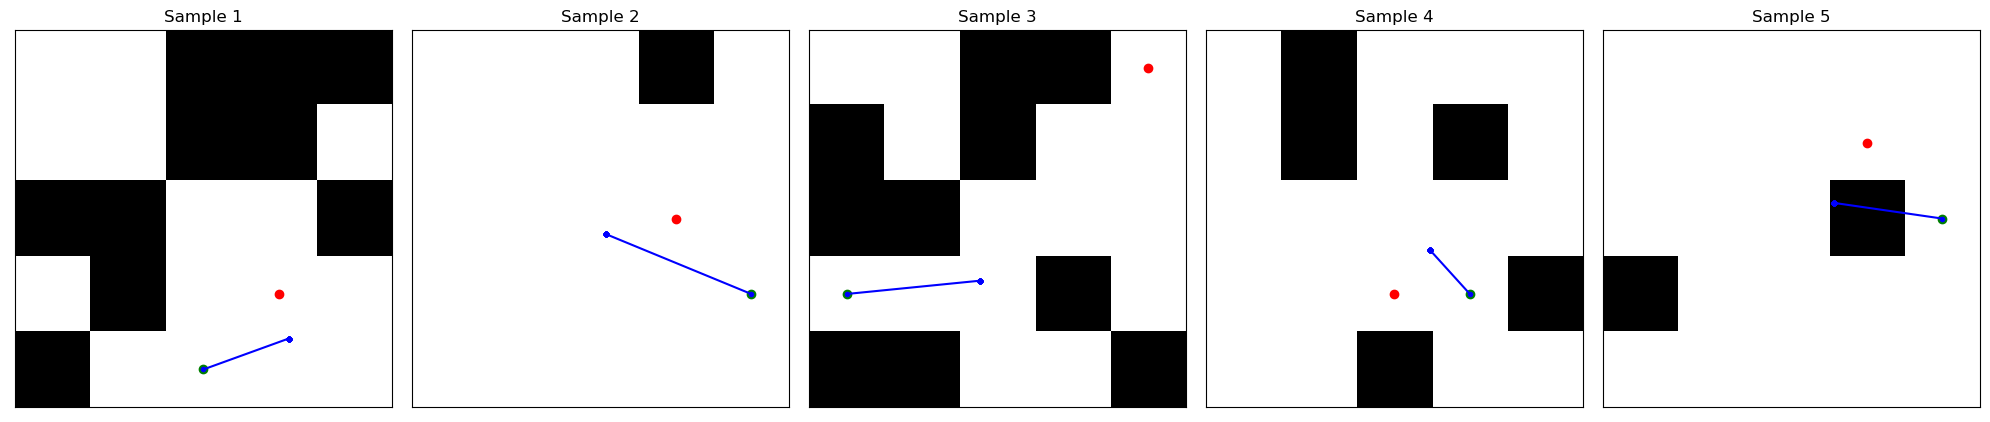

: 

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
import pickle

# Load the trained model
trained_model_path = 'trained_model.pth'
try:
    model = torch.load(trained_model_path)
except FileNotFoundError:
    print(f"Model file '{trained_model_path}' not found. Please ensure the model is saved correctly after training.")
    exit()
model.eval()

# Load the dataset for sampling
with open('grid_world_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

# Define a custom dataset for PyTorch
class PathDataset:
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        grid = torch.tensor(data["grid"], dtype=torch.float32).unsqueeze(0)  # Shape: (1, grid_size, grid_size)
        start = torch.tensor(data["start"], dtype=torch.float32)
        goal = torch.tensor(data["goal"], dtype=torch.float32)
        return grid, start, goal

path_dataset = PathDataset(dataset)

def pad_waypoints(waypoints, max_len):
    padded_waypoints = []
    for w in waypoints:
        pad_size = max_len - len(w)
        padded_w = np.pad(w, ((0, pad_size), (0, 0)), mode='constant', constant_values=0)
        padded_waypoints.append(padded_w)
    return torch.tensor(padded_waypoints, dtype=torch.float32)

# Function to perform conditional sampling
def conditional_sampling(model, dataset, num_samples=5):
    model.eval()
    sampled_paths = []
    for idx in range(num_samples):
        grid, start, goal = dataset[idx]
        grid = grid.unsqueeze(0)  # Add batch dimension

        # Flatten the grid input to match the model's expected input dimensions
        # Keep the grid in its original 4D shape (batch_size, channels, height, width)

        # Start generating waypoints from start to goal
        waypoints = [start.numpy()]
        current_position = start

        for _ in range(20):  # Generate up to 20 waypoints
            with torch.no_grad():
                next_waypoint = model(grid).squeeze(0).numpy()
                waypoints.append(next_waypoint)
                current_position = torch.tensor(next_waypoint, dtype=torch.float32)

                # Stop if we reach close to the goal
                if np.linalg.norm(current_position.numpy() - goal.numpy()) < 0.5:
                    break

        sampled_paths.append((grid.squeeze(0).numpy(), start.numpy(), goal.numpy(), np.array(waypoints)))

    return sampled_paths

# Generate and visualize sampled paths
sampled_paths = conditional_sampling(model, path_dataset, num_samples=5)

def visualize_sampled_paths(sampled_paths):
    num_samples = len(sampled_paths)
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for i, (grid, start, goal, waypoints) in enumerate(sampled_paths):
        ax = axes[i]
        ax.imshow(grid[0], cmap='gray_r')
        ax.plot(start[1], start[0], "go", label="Start")
        ax.plot(goal[1], goal[0], "ro", label="Goal")
        ax.plot(waypoints[:, 1], waypoints[:, 0], "b.-", label="Path")
        ax.set_title(f"Sample {i+1}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

# Visualize the sampled paths
visualize_sampled_paths(sampled_paths)
